In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from DataFields import DataFields
from DataFields import DateReportedFields
from ProjectFunctions import get_columns_from_chunk, convert_date_to_binary, drop_rows_with_na_greater_than
from ProjectFunctions import map_education_levels, map_vascular_levels

from typing import Callable, Any

UKBB_PATH = "~/biobank/ukb672220.csv"

# A dictionary containing the used features
datafields = DataFields

# Features of conditions specified by date
datereportedfields = DateReportedFields

#### Measure the distribution of age

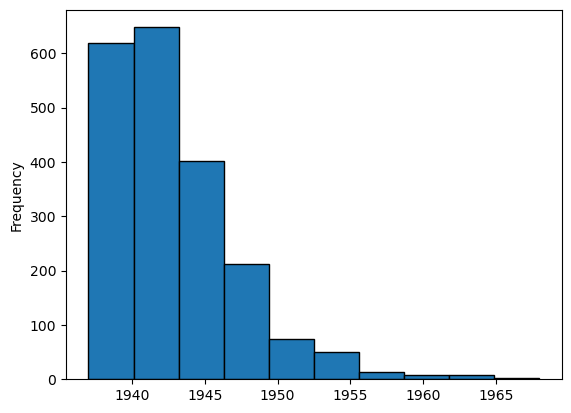

In [2]:
df = pd.read_csv("diagnosed_processed.csv")

# plot histogram of the birth year
df["Birth Year"].plot(kind='hist', bins=10, edgecolor='black')
birth_year_counts_histogram, birth_year_histogram_edges = np.histogram(df["Birth Year"], bins=10)

#### Extract samples of patients undiagnosed with vascular dementia with similar birth year

##### Define features to drop if na

In [3]:
drop_if_na_list = [
    "Smoking Status",
    "Education",
    "Ever Smoked",
    "Report of vascular problems",
    "Diabetes Diagnosed By Doctor",
    "Report of stroke",
    
    "Seropositive Rheumatoid Arthritis",
    "Other Rheumatoid Arthritis",
    "Juvenile Arthritis",
    "Other Arthritis",
    "Psoriatic and enteropathic arthropathies",
    "Multiple Sclerosis",
    "Crohn's disease",
    "Ulcerative Colitis",
    "Thyrotoxicosis (Grave's disease)",
    "Sjogren Disease (M35)",
    "Myasthenia gravis",
    "Diagnosed with Coeliac disease",
    "B12 deficiency anaemia",
    
    "Alanine aminotransferase",
    "Albumin",
    "Alkaline phosphatase",
    "Apolipoprotein A",
    "Apolipoprotein B",
    "Aspartate aminotransferase",
    "C-reactive protein",
    "Calcium",
    "Cholesterol",
    "Creatinine",
    "Cystatin C",
    "Direct bilirubin",
    "Gamma glutamyltransferase",
    "Glucose",
    "Glycated haemoglobin (HbA1c)",
    "HDL cholesterol",
    "IGF-1",
    "LDL direct",
    "Lipoprotein A",
    "Phosphate",
    "SHBG",
    "Testosterone",
    "Total bilirubin",
    "Total protein",
    "Triglycerides",
    "Urate",
    "Urea",
    "Vitamin D",
    
    "Basophil count",
    "Basophil percentage",
    "Eosinophil count",
    "Eosinophil percentage",
    "Haematocrit percentage",
    "Haemoglobin concentration",
    "High light scatter reticulocyte count",
    "High light scatter reticulocyte percentage",
    "Immature reticulocyte fraction",
    "Lymphocyte count",
    "Lymphocyte percentage",
    "Mean corpuscular haemoglobin",
    "Mean corpuscular haemoglobin concentration",
    "Mean corpuscular volume",
    "Mean platelet (thrombocyte) volume",
    "Mean reticulocyte volume",
    "Mean sphered cell volume",
    "Monocyte count",
    "Monocyte percentage",
    "Neutrophil count",
    "Neutrophil percentage",
    "Nucleated red blood cell count",
    "Nucleated red blood cell percentage",
    "Platelet count",
    "Platelet crit",
    "Platelet distribution width",
    "Red blood cell (erythrocyte) count",
    "Red blood cell (erythrocyte) distribution width",
    "Reticulocyte count",
    "Reticulocyte percentage",
    "White blood cell (leukocyte) count",
    "Blood Pressure Diastolic",
    "Blood Pressure Systolic",
    "Pulse Rate at Blood Pressure"
]

##### Do this

In [4]:
# vd_1 and vd_2 used to drop diagnosed patients
vd_1 = "Vascular Dementia Date First Reported"
vd_2 = "Date of vascular dementia report"

def filter_chunk(chunk):
    # remove unnecessary columns first.
    chunk = get_columns_from_chunk(chunk, datafields, oldest=True)

    chunk = map_education_levels(chunk)
    
    chunk["Report of vascular problems"] = chunk["Report of vascular problems"].replace({-7: 0, -3: pd.NA})

    # take only patients undiagnosed with vascular dementia
    chunk[chunk[vd_1].isna() & chunk[vd_2].isna()] 
    
    # filter by condition function
    mask = condition_function(chunk[column])
    filtered_chunk = chunk.loc[mask]
    
    # convert items with value less than 0 to NA
    #filtered_chunk = filtered_chunk.mask(filtered_chunk.select_dtypes(include='number') < 0)
    
    # drop all NA
    filtered_chunk = filtered_chunk.dropna(subset=drop_if_na_list) # drop if missing value for some columns

    return filtered_chunk


In [5]:
# Sample "count" rows from dataframe following a condtion by chunks randomly.
def sample_by_condition(file_path, column, condition_function, count, samples_per_chunk, vd_cols, chunksize=20000):
    result = pd.DataFrame()
    samples_collected = 0
    
    for chunk in pd.read_csv(file_path, chunksize=chunksize, low_memory=False):
            
        filtered_chunk = filter_chunk(chunk)
        
        if filtered_chunk.empty:
            continue
        
        remaining_samples = count - samples_collected
        if remaining_samples <= 0:
            break
            
        # choose randomly if too many were collected
        k = min(samples_per_chunk, len(filtered_chunk))
        chunk_sample = filtered_chunk.sample(n=k)
    
        if result.empty:
            result = chunk_sample
        else:
            result = pd.concat([result, chunk_sample], ignore_index=True, copy=False)

        samples_collected += len(chunk_sample)

        if samples_collected >= count:
            break
            
    if samples_collected > count:
        return result.sample(n=count)
    else:
        return result

In [6]:
per_chunk = 500 # maximum samples to take from a single chunk per histogram column
col_name = "Birth Year" # The column to use as a rule for "sample_by_condition"

const = 20 # constant addition per histogram

undiagnosed_df = pd.DataFrame()

for i in range(len(birth_year_counts_histogram)):
    start, end = birth_year_histogram_edges[i], birth_year_histogram_edges[i+1]
    count = birth_year_counts_histogram[i]
    
    df = sample_by_condition(UKBB_PATH, 
                             col_name, 
                             lambda x:(x >= start) & (x < end), 
                             count + const, 
                             per_chunk, 
                             [vd_1, vd_2])
    
    undiagnosed_df = pd.concat([undiagnosed_df, df], ignore_index=True)

# drop vascular dementia columns
undiagnosed_df = undiagnosed_df.drop(columns=[vd_1, vd_2])

# assign undiagnosed
undiagnosed_df["Vascular Dementia Report Date"] = pd.NA

# drop id column
undiagnosed_df = undiagnosed_df.drop(columns=["id"])

NameError: name 'vd_cols' is not defined

#### Save the CSV, and analyse the extracted data

In [ ]:
from ProjectFunctions import count_na_in_dataframe

# count number of NA per column
count_na_in_dataframe(undiagnosed_df)

# Plot Brith Year histogram, compare with diagnosed patients
undiagnosed_df["Birth Year"].plot(kind='hist', bins=10, edgecolor='black')

undiagnosed_df.to_csv("undiagnosed.csv", index=False)

# analyze distributions
undiagnosed_df.describe()